# 5.2 Preliminaries

## 5.2.1 Kinematic Configuration

 Kinematics: The calculus describing the effect of control actions on the configuration of a robot.
 
 Configuration of a rigid mobile robot: three-dimensional Cartesian coordinate and its three Euler angles (roll, pitch, yaw)

 Pose: two-dimensional planar coordinates $(x,y)$ relative to an external coordinate frame, along with its angular orientation $\theta$.
 
$\begin{bmatrix}x \\ y \\ \theta \end{bmatrix}$

Text(0, 0.5, 'y')

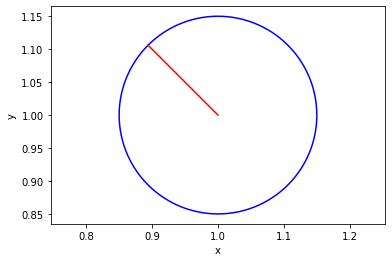

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def draw_robot(cx, cy, angle, r=0.15):
    """ (cx, cy): the center of a robot (unit: m)
        angle: heading angle in rad. 0:points into the x-axis, 0.5pi:points into the y-axis
        r: the radius of a robot (unit: m)
    """
    robot_x = []
    robot_y = []
    for a in range(360):
        a_rad = np.pi * a / 180.0
        xi = r*np.cos(a_rad) + cx
        yi = r*np.sin(a_rad) + cy
        robot_x.append(xi)
        robot_y.append(yi)
    
    plt.plot(robot_x, robot_y, c='b')
    heading_x = r*np.cos(angle) + cx
    heading_y = r*np.sin(angle) + cy
    plt.plot([cx, heading_x], [cy, heading_y], c='r')


plt.figure()
draw_robot(1, 1, 135 * np.pi / 180.0)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')


## 5.2.2 Probabilistic Kinematics

$p(x_t \mid u_t, x_{t-1})$

- $x_t, x_{t-1}$: robot poses
- $u_t$: motion command, odometry model (distance traveled, angle turned).



# 5.3 Velocity Motion Model

- $u_t = \begin{bmatrix} v_t \\ w_t \end{bmatrix}$
- Positive rotational velocities $w_t$ induce a counterclockwise rotation (left turns).
- Positives $v_t$ correspond to forward motion.



## 5.3.1 Closed Form Calculation

A possible algorithm for computing the probability $p(x_t \mid u_t, x_{t-1})$ is shown in Table 5.1. It accepts as input an initial pose $x_{t-1} = (x, y, \theta)^T$, a control $u_t = (v, w)^T$, and a hypothesized successor pose $x_t = (x', y', \theta')^T$. It outputs the probability $p(x_t \mid u_t, x_{t-1})$ of being at $x_t$ after executing control $u_t$ beginning in state $x_{t-1}$, assuming that the control is carried out for the fixed duration $\Delta t$.

The parameters $\alpha_1$ to $\alpha_6$ are robot-specific motion error parameters.
  - $\alpha_1, \alpha_2$ : transitional error
  - $\alpha_3, \alpha_4$ : angular error

The function $prob(x, b^2)$ models the motion error. It computes the proability of its parameter $x$ under a zero-centered random variable with variance $b^2$.

In [42]:
import numpy as np

def prob_normal_distribution(a, b2):
   print('a: ', a)
   print('b2: ', b2)

   y = 1.0 / np.sqrt(2.0 * np.pi * b2) * np.exp(-1 / 2 * (a**2) / b2 )

   print('1/sqrt ', 1.0 / np.sqrt(2.0 * np.pi * b2) )
   print('exp ', np.exp(-1 / 2 * (a**2) / b2 ))
   print('y ', y)

   return y

def prob_triangular_distribution(a, b2):
   y = 1.0 / np.sqrt(6 * b2) - np.abs(a) / (6*b2)

   return np.clip(y, 0)

def motion_model_velocity(pos_cur, command_cur, pos_prev, prob, alpha, delta_t=0.1):
   """pos_cur: x_t
      command_cur: u_t
      pos_prev: x_{t-1}
      prob: probability function
   """
   x_cur = pos_cur[0]
   y_cur = pos_cur[1]
   angle_cur = pos_cur[2]

   x_prev = pos_prev[0]
   y_prev = pos_prev[1]
   angle_prev = pos_prev[2]

   v = command_cur[0]
   w = command_cur[1]

   sin_a_prev = np.sin(angle_prev)
   cos_a_prev = np.cos(angle_prev)

   num = (x_prev - x_cur)*cos_a_prev + (y_prev - y_cur)*sin_a_prev
   denom = (y_prev - y_cur)*cos_a_prev - (x_prev - x_cur)*sin_a_prev
   mu = 1/2 * num / denom

   # center of circle (xc, yc)
   xc = (x_prev + x_cur) / 2.0 + mu * (y_prev - y_cur)
   yc = (y_prev + y_cur) / 2.0 + mu * (x_cur - x_prev)
   rc = np.sqrt((x_prev - xc)**2 + (y_prev - yc)**2)
   
   delta_angle = np.arctan2(y_cur - yc, x_cur - xc) - np.arctan2(y_prev - yc, x_prev - xc)
   v_hat = delta_angle / delta_t * rc
   w_hat = delta_angle / delta_t
   g_hat = (angle_cur - angle_prev) / delta_t - w_hat

   a1 = alpha[0]
   a2 = alpha[1]
   a3 = alpha[2]
   a4 = alpha[3]
   a5 = alpha[4]
   a6 = alpha[5]

   pv = prob(v - v_hat, a1*v**2 + a2*w**2)
   pw = prob(w - w_hat, a3*v**2 + a4*w**2)
   pg = prob(g_hat, a5*v**2 + a6*w**2)

   return pv, pw, pg


pos_cur = [1.0, 0.1, 0.0]
pos_prev = [0.54, 0.0, 0.0*np.pi]
command_cur = [0.5, 0.1*np.pi]
alpha = [0.2, 0.2, 0.01, 0.01, 0.01, 0.01]
delta_t = 1.0

pv, pw, pg = motion_model_velocity(pos_cur, command_cur, pos_prev, prob_normal_distribution, alpha, delta_t)

print(pv, pw, pg)



a:  0.02564152522257168
b2:  0.06973920880217872
1/sqrt  1.5106767937256231
exp  0.9952971894000514
y  1.503572366886994
a:  -0.11396210176866362
b2:  0.0034869604401089357
1/sqrt  6.755952005603843
exp  0.15531883019037607
y  1.049326562332714
a:  -0.4281213671276429
b2:  0.0034869604401089357
1/sqrt  6.755952005603843
exp  3.854029158631915e-12
y  2.603763602391498e-11
1.503572366886994 1.049326562332714 2.603763602391498e-11
